# Detection of the Higgs boson

From data collected at the LHC this project will try to determine the singnal strength and corss section of the Higgs decay into two Z-bosons. The reaction channel is given by
$$
\text{H} \rightarrow \text{Z} +\text{Z}^* \rightarrow \mu_1+\mu_2+\mu_3+\mu_4 \text{ or } \mu_1+\mu_2+e_1+e_2.
$$
where the asterix indicates that one of the Z-bosons is offshell. The data is stored in ROOT-files and consists of many events. An event is one single detection of a reaction. The most important variavles stored in an event is leptonic content and its transverese momentum, pseudorapidity, angle in the transverese plane and charge.


In order to compare the SM predictions to the data MC simulations are done based on the predictions. These are simulations of different production channels that can either be part of the Higgs signal we want to find or the background. The events produced by these simulations are stored in the same way as the actual data, but in addition they also have a weight. This weight is based on the experimental luminosity and the theoretical cross section of that production channel. 


In [8]:
# Packages needed to do the procedure
import uproot
import os
from tqdm import tqdm
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
from itertools import product
from scipy.stats import binned_statistic
from scipy.special import factorial
from scipy.optimize import minimize
from time import sleep
import winsound

import ROOT
import scipy as sp
import scipy.stats as ss
import scipy.integrate as integrate
import scipy.special as special
from scipy.integrate import quad
import matplotlib.patches as mpatches
from matplotlib.pyplot import figure
import pyhf
import seaborn as sns

import warnings

warnings.simplefilter(
    action="ignore", category=FutureWarning
)  # Remove some pandas error
import jupyter_black

jupyter_black.load()

# Data Filtering

## Event class

This class is used to store all the data from one event that we want to keep. The stored components for all leptons are:
- pt : The transverse momentum
- mass : The mass
- eta : The psuedo-rapidity
- phi : Angle in the transverse plane

In addition the folowing general properties of the events are stored:
- event_type : What lepton flavor the event consists of
- weight : The weight of the simulation, set to 1 if data
  
The the following invariant masses are reconstructed and stored:
- invariant_mass : The total invariant mass of the event
- invariant_mass_1 : The invariant mass of the first leptone pair
- invariant_mass_2 : The invariant mass of the first leptone pair

In [9]:
@dataclass
class Event:
    """
    Class for structuring the data to be stored in pandas datafram since
    dataclass and pandas are compatible
    """

    # Define parameters that are stored
    l1_pt: float
    l2_pt: float
    l3_pt: float
    l4_pt: float

    l1_mass: float
    l2_mass: float
    l3_mass: float
    l4_mass: float

    l1_eta: float
    l2_eta: float
    l3_eta: float
    l4_eta: float

    l1_phi: float
    l2_phi: float
    l3_phi: float
    l4_phi: float

    # What leptons the event is form
    event_type: str
    # What the weight is, relevant for simulated
    weight: float

    invariant_mass: float = 0
    invariant_mass_1: float = 0
    invariant_mass_2: float = 0

    def __init__(
        self,
        muon_pt,
        muon_mass,
        muon_eta,
        muon_phi,
        electron_pt,
        electron_mass,
        electron_eta,
        electron_phi,
        i1,
        i2,
        i3,
        i4,
        weight,
        event_type,
    ):

        self.event_type = event_type

        # Check if 4 Muons or 2 Muons and 2 electrons
        # electrons are always stored as second pair
        if event_type == "4Muon":
            muon4 = True
        else:
            muon4 = False

        if muon4 == True:
            self.l1_pt = muon_pt[i1]
            self.l2_pt = muon_pt[i2]
            self.l3_pt = muon_pt[i3]
            self.l4_pt = muon_pt[i4]

            self.l1_mass = muon_mass[i1]
            self.l2_mass = muon_mass[i2]
            self.l3_mass = muon_mass[i3]
            self.l4_mass = muon_mass[i4]

            self.l1_eta = muon_eta[i1]
            self.l2_eta = muon_eta[i2]
            self.l3_eta = muon_eta[i3]
            self.l4_eta = muon_eta[i4]

            self.l1_phi = muon_phi[i1]
            self.l2_phi = muon_phi[i2]
            self.l3_phi = muon_phi[i3]
            self.l4_phi = muon_phi[i4]
        else:
            self.l1_pt = muon_pt[i1]
            self.l2_pt = muon_pt[i2]
            self.l3_pt = electron_pt[i3]
            self.l4_pt = electron_pt[i4]

            self.l1_mass = muon_mass[i1]
            self.l2_mass = muon_mass[i2]
            self.l3_mass = electron_mass[i3]
            self.l4_mass = electron_mass[i4]

            self.l1_eta = muon_eta[i1]
            self.l2_eta = muon_eta[i2]
            self.l3_eta = electron_eta[i3]
            self.l4_eta = electron_eta[i4]

            self.l1_phi = muon_phi[i1]
            self.l2_phi = muon_phi[i2]
            self.l3_phi = electron_phi[i3]
            self.l4_phi = electron_phi[i4]
        self.weight = weight
        self.__post_init__()

    def __post_init__(self):
        """Get called after init to construct inveriant mass outside init"""
        M2p1 = (
            2
            * self.l1_pt
            * self.l2_pt
            * (np.cosh(self.l1_eta - self.l2_eta) - np.cos(self.l1_phi - self.l2_phi))
            + self.l1_mass**2
            + self.l2_mass**2
        )

        M2p2 = (
            2
            * self.l3_pt
            * self.l4_pt
            * (np.cosh(self.l3_eta - self.l4_eta) - np.cos(self.l3_phi - self.l4_phi))
            + self.l3_mass**2
            + self.l4_mass**2
        )

        self.invariant_mass_1 = np.sqrt(M2p1)
        self.invariant_mass_2 = np.sqrt(M2p2)

        invariant_mass = 0
        pt_list = [self.l1_pt, self.l2_pt, self.l3_pt, self.l4_pt]
        eta_list = [self.l1_eta, self.l2_eta, self.l3_eta, self.l4_eta]
        phi_list = [self.l1_phi, self.l2_phi, self.l3_phi, self.l4_phi]

        for i, (pt_1, eta_1, phi_1) in enumerate(zip(pt_list, eta_list, phi_list)):
            for pt_2, eta_2, phi_2 in zip(
                pt_list[i + 1 :], eta_list[i + 1 :], phi_list[i + 1 :]
            ):
                invariant_mass += (
                    2 * pt_1 * pt_2 * (np.cosh(eta_1 - eta_2) - np.cos(phi_1 - phi_2))
                )
        invariant_mass += (
            self.l1_mass**2
            + self.l2_mass**2
            + self.l3_mass**2
            + self.l4_mass**2
        )

        self.invariant_mass = np.sqrt(invariant_mass)

# Reading files and filtering data

The ROOT data is downloaded and kept on the local computer. The folowing class is used to read and filter a ROOT-file. There are several filter in place. They are shortly sumarised as:

- The event has to trigger one of three trigges. They are the used by the detector to trigger a storage of the events types we want. Therefore they need to be checked both for the simulation and data. The triggers are named:
    - HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL
    - HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8
    - HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass8


- In order to have reliable events there are certain quality requierments:
    - Only leptons with a transversmomentum larger than 5 eV.
    - The two largest muon transverse have to be larger than 20 eV and 10 eV respectively.
    - The leptons have to be isolated, maning that their pfRelIso03_all $< 0.15$ .
    - The reconstruction of Muons have to satisfy the thightId tag.
    - The quality of reconstruction of electrons have to be above 2.
    
    
- The leptonic content has to be in accordance with the channels we whis to study. This means that the following are required:
    - At least two muons that have opposite charge
    - At least two possible lepton pairs, where a pair has to have be of same flavor and different charge.
    - One of the possible pairs have to be in the eV range $[106,50]$ and is several possible pairs in this range the one closest to 91 eV is chosen.
    - The second pair have to be in the eV range $[115,15]$ and is several possible pairs in this range the largest one is chosen. 
    

- The simulated events also contain a weight which is based on the know luminocity of the collider.

In [10]:
@dataclass
class FileRead:
    """
    Class to interact with the root files and the dataframes
    from the filtered data.
    """

    # names of variables to be used from root files
    names = [
        "Electron_mass",
        "Electron_charge",
        "Electron_pt",
        "Electron_cutBased",
        "Electron_eta",
        "Electron_phi",
        "Electron_pfRelIso03_all",
        "Muon_charge",
        "Muon_mass",
        "Muon_pt",
        "Muon_tightId",
        "Muon_pt",
        "Muon_mass",
        "Muon_eta",
        "Muon_phi",
        "Muon_pfRelIso03_all",
        "eventWeightLumi",
    ]

    # names of triggers to be used from root files
    trigger_names = [
        "HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL",
        "HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8",
        "HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass8",
    ]

    # Parameters for filtering the data
    min_muon: float = 2  # minum number of muon in event
    min_muon_pt_1: float = 20  # Minimum pt of muon with largest
    min_muon_pt_2: float = 10  # Minimum pt of muon with second largets
    min_lepton_pt: float = 5  # Minimum pt of accepted leptons
    max_isolated: float = 0.15  # Max isolation value
    Z_mass: float = 91  # Z_mass to for first pair
    pair1_mass_max: float = 106  # Maximum value of first lepton pair
    pair1_mass_min: float = 50  # Min value of first lepton pair
    Z_off_mass: float = (
        115  # The target value of second pair closest to this is exepted
    )
    pair2_mass_max: float = 115  # Maximum value of second lepton pair
    pair2_mass_min: float = 15  # Min value of second lepton pair
    electron_quality_min: float = (
        2  # The cutBased quality of electron have to be strictly larger than this
    )

    # Tags for the different type of lepton pairing
    muon4_tag = "4Muon"  # all 4 leptons are muons
    muon2electron2_tag = (
        "2Muon2Electron"  # the on shell pair is muons and the other electrons
    )
    electron2muon2_tag = (
        "2Electron2Muon"  # the on shell pair is electrons and the other muons
    )

    def read(cls, file_path: str):
        """
        Reads a single root file (file_path) and returns a pandas dataframe
        with all the filtered events.
        """

        # Open the file with uproot
        with uproot.open(file_path)["Events"] as events:

            # get variables and store in dictionary
            variable_dict = cls.get_variables(events)

            # storage for events
            accepted_events = []
            # iterate through all the events in the file
            for i in range(variable_dict["size"]):

                #### Checking triggers ####

                # List of boolean values for the triggers
                trigger_list = [
                    variable_dict[trigger][i] for trigger in cls.trigger_names
                ]
                # The logical or of the triggers, if no triggers are True it goes to the next event
                if sum(trigger_list) == 0:
                    continue

                #### Assigning dictionary values ####
                # To ease the procesing and filtering the variables for the event are added to variables
                # All properties are sorted on the pt of the lepton

                # statistical weight of event, 1 if data
                weight = variable_dict["eventWeightLumi"][i]
                # Lepton transverse momentum
                muon_pt = variable_dict["Muon_pt"][i]
                electron_pt = variable_dict["Electron_pt"][i]
                # Lepton reconstrucion quality
                muon_tightId = variable_dict["Muon_tightId"][i]  # bool
                electron_cutBased = variable_dict["Electron_cutBased"][
                    i
                ]  # integer specifying quality
                # Lepton isolation
                muon_iso = variable_dict["Muon_pfRelIso03_all"][i]
                electron_iso = variable_dict["Electron_pfRelIso03_all"][i]
                # Lepton pseudo-rapidity
                muon_eta = variable_dict["Muon_eta"][i][muon_keep]
                electron_eta = variable_dict["Electron_eta"][i][electron_keep]
                # Lepton transverse plane angle
                muon_phi = variable_dict["Muon_phi"][i][muon_keep]
                electron_phi = variable_dict["Electron_phi"][i][electron_keep]
                # Lepton mass
                muon_mass = variable_dict["Muon_mass"][i][muon_keep]
                electron_mass = variable_dict["Electron_mass"][i][electron_keep]

                #### Filtering on general muon criteria ####

                # Require atleast 2 muons
                if len(muon_pt) < cls.min_muon:
                    continue

                # Require muon pt criterias
                if muon_pt[0] < cls.min_muon_pt_1:
                    continue
                if muon_pt[1] < cls.min_muon_pt_2:
                    continue

                # Require that the two largest momentum muons are isolated
                if (muon_iso[0] > cls.max_isolated) or (muon_iso[1] > cls.max_isolated):
                    continue

                #### Enforce quality, isolation and pt requirements ####

                # Filtering out leptons that are not of valid quality or have to low pt
                muon_keep = (
                    (muon_pt > cls.min_lepton_pt)
                    * (muon_iso < cls.max_isolated)
                    * muon_tightId
                )
                electron_keep = (
                    (electron_pt > cls.min_lepton_pt)
                    * (electron_iso < cls.max_isolated)
                    * (electron_cutBased > cls.electron_quality_min)
                )

                # Removing the leptons that wheren't valid
                muon_pt = muon_pt[muon_keep]
                muon_charge = variable_dict["Muon_charge"][i][muon_keep]
                electron_pt = electron_pt[electron_keep]
                electron_charge = variable_dict["Electron_charge"][i][electron_keep]

                #### Enforce general pair requierments ####
                # This is done so the calculation of all pairs for those events which
                # anyway would be accepted is avoided

                # Compute the number of possible pairs for each lepton
                num_muon_pairs = len(muon_pt) // 2 - np.floor(
                    abs(np.sum(muon_charge)) / 2
                )
                num_electron_pairs = len(electron_pt) // 2 - np.floor(
                    abs(np.sum(electron_charge)) / 2
                )
                # total lepton pairs
                num_pairs = num_electron_pairs + num_muon_pairs
                # go to next iteration if no muon pairs or just one pair
                if num_muon_pairs < 1 or num_pairs < 2:
                    continue

                #### Finding possible pairs with invariant mass ####

                muon_invariant_masses = cls.get_pairs_with_mass(
                    muon_charge, muon_pt, muon_eta, muon_phi, muon_mass
                )
                electron_invariant_masses = cls.get_pairs_with_mass(
                    electron_charge,
                    electron_pt,
                    electron_eta,
                    electron_phi,
                    electron_mass,
                )

                #### Checking which pair are onshell within the limits ####
                # The bool no_muon and no_electron speify if there was
                # found onshell pairs or not.

                # Checking if any muon pair are onshell within the limits, if not no_muon is true
                muon_allowed_masses = (
                    muon_invariant_masses[:, -1] < cls.pair1_mass_max
                ) * (muon_invariant_masses[:, -1] > cls.pair1_mass_min)
                no_muon = True
                if sum(muon_allowed_masses) > 0:
                    no_muon = False
                    # If any allowed store the "most" onshell
                    best_muon_invariant_mass_diff = np.min(
                        np.abs(
                            muon_invariant_masses[muon_allowed_masses, -1] - cls.Z_mass
                        )
                    )

                # Checking if any electron pair are onshell within the limits, if not no_electon is true
                no_electron = True
                if len(electron_invariant_masses) > 0:
                    # There are electons so can see if any allowed
                    electron_allowed_masses = (
                        electron_invariant_masses[:, -1] < cls.pair1_mass_max
                    ) * (electron_invariant_masses[:, -1] > cls.pair1_mass_min)
                    # If any allowed store the "most" onshell
                    if sum(electron_allowed_masses) > 0:
                        best_electron_invariant_mass_diff = np.min(
                            np.abs(
                                electron_invariant_masses[electron_allowed_masses, -1]
                                - cls.Z_mass
                            )
                        )
                        no_electron = False

                #### Final pair making and storing ####

                if no_electron and no_muon:
                    # No pairs possible
                    continue

                if not no_electron and no_muon:
                    # Onshell pair is a electon pair

                    # Store the value of electron pair
                    pair_1 = np.where(
                        np.abs(electron_invariant_masses[:, -1] - cls.Z_mass)
                        == best_electron_invariant_mass_diff
                    )[0]
                    i1 = int(electron_invariant_masses[pair_1[0], 0])
                    i2 = int(electron_invariant_masses[pair_1[0], 1])

                    # Since the second pair must be muon search through the muon pair invariant masses for best if any
                    i3, i4, _, found = cls.find_2pair(
                        muon_invariant_masses,
                        electron_invariant_masses,
                        electron_live=False,
                    )

                    # Store the event if a second pair was found
                    if found:
                        accepted_events.append(
                            Event(
                                muon_pt,
                                muon_mass,
                                muon_eta,
                                muon_phi,
                                electron_pt,
                                electron_mass,
                                electron_eta,
                                electron_phi,
                                i3,
                                i4,
                                i1,
                                i2,
                                weight,
                                cls.electron2muon2_tag,
                            )
                        )
                        continue
                    continue

                if no_electron and not no_muon:
                    # Onshell pair is a muon pair

                    # Store the value of the muon pair
                    pair_1 = np.where(
                        np.abs(muon_invariant_masses[:, -1] - cls.Z_mass)
                        == best_muon_invariant_mass_diff
                    )[0]
                    i1 = int(muon_invariant_masses[pair_1[0], 0])
                    i2 = int(muon_invariant_masses[pair_1[0], 1])

                    # remove the pairs from the list that one of the first was part of
                    muon_invariant_masses = cls.remove_indicies(
                        muon_invariant_masses, i1, i2
                    )

                    # search for a second pair, now it can be both electron or muon
                    i3, i4, electron_found, found = cls.find_2pair(
                        muon_invariant_masses, electron_invariant_masses
                    )
                    # check what pair was found if found and store
                    if found and electron_found:
                        # Electron pair as second found
                        accepted_events.append(
                            Event(
                                muon_pt,
                                muon_mass,
                                muon_eta,
                                muon_phi,
                                electron_pt,
                                electron_mass,
                                electron_eta,
                                electron_phi,
                                i1,
                                i2,
                                i3,
                                i4,
                                weight,
                                cls.muon2electron2_tag,
                            )
                        )
                    if found and not electron_found:
                        # Muon pair as second found
                        accepted_events.append(
                            Event(
                                muon_pt,
                                muon_mass,
                                muon_eta,
                                muon_phi,
                                electron_pt,
                                electron_mass,
                                electron_eta,
                                electron_phi,
                                i1,
                                i2,
                                i3,
                                i4,
                                weight,
                                cls.muon4_tag,
                            )
                        )
                    continue

                if not no_electron and not no_muon:
                    # Both electron and muon pair can be onshell os choose the one closest as first pair
                    muon_best = (
                        best_electron_invariant_mass_diff
                        < best_electron_invariant_mass_diff
                    )

                    if muon_best:
                        # The muon pair is the "most" onshell

                        # store value of muon pair
                        pair_1 = np.where(
                            np.abs(muon_invariant_masses[:, -1] - cls.Z_mass)
                            == best_muon_invariant_mass_diff
                        )[0]
                        i1 = int(muon_invariant_masses[pair_1[0], 0])
                        i2 = int(muon_invariant_masses[pair_1[0], 1])

                        # remove the pairs from the list that one of the first was part of
                        muon_invariant_masses = cls.remove_indicies(
                            muon_invariant_masses, i1, i2
                        )

                        # search for a second pair, now it can be both electron or muon
                        i3, i4, electron_found, found = cls.find_2pair(
                            muon_invariant_masses, electron_invariant_masses
                        )
                        # check what pair was found
                        if found and electron_found:
                            # electonr pair found as second pair
                            accepted_events.append(
                                Event(
                                    muon_pt,
                                    muon_mass,
                                    muon_eta,
                                    muon_phi,
                                    electron_pt,
                                    electron_mass,
                                    electron_eta,
                                    electron_phi,
                                    i1,
                                    i2,
                                    i3,
                                    i4,
                                    weight,
                                    cls.muon2electron2_tag,
                                )
                            )
                        if found and not electron_found:
                            # muon pair found as second pair
                            accepted_events.append(
                                Event(
                                    muon_pt,
                                    muon_mass,
                                    muon_eta,
                                    muon_phi,
                                    electron_pt,
                                    electron_mass,
                                    electron_eta,
                                    electron_phi,
                                    i1,
                                    i2,
                                    i3,
                                    i4,
                                    weight,
                                    cls.muon4_tag,
                                )
                            )
                        continue
                    if not muon_best:
                        # The Electron pair is the "most" onshell

                        # Store values of electron pair
                        pair_1 = np.where(
                            np.abs(electron_invariant_masses[:, -1] - cls.Z_mass)
                            == best_electron_invariant_mass_diff
                        )[0]
                        i1 = int(electron_invariant_masses[pair_1[0], 0])
                        i2 = int(electron_invariant_masses[pair_1[0], 1])

                        # Since the second pair must be muon search through the muon pair invariant masses for best if any
                        i3, i4, _, found = cls.find_2pair(
                            muon_invariant_masses,
                            electron_invariant_masses,
                            electron_live=False,
                        )  # no electron as second since first

                        # Check if a muon pair if found and store if
                        if found:
                            accepted_events.append(
                                Event(
                                    muon_pt,
                                    muon_mass,
                                    muon_eta,
                                    muon_phi,
                                    electron_pt,
                                    electron_mass,
                                    electron_eta,
                                    electron_phi,
                                    i3,
                                    i4,
                                    i1,
                                    i2,
                                    weight,
                                    cls.electron2muon2_tag,
                                )
                            )

        # return the accepted events as a dataframe since they are a class made
        # by the dataclass decorator the pandas knows how to store them
        return pd.DataFrame(accepted_events)

    def read_list(cls, file_paths, **kwargs):
        """
        Reads a whole list of filepaths and returns a dataframe of all acepted events
        calls the read funciton repeted times
        """
        accepted_events = pd.DataFrame()
        for file_path in tqdm(file_paths):
            accepted_events = pd.concat(
                [accepted_events, cls.read(file_path, **kwargs)]
            )

        return accepted_events

    #### Helper functions for the read function ####
    def get_variables(self, events):
        """Reads in all the variables into an dictionary"""

        # read all non-trigger values
        variable_dict = {name: events[name].array(library="np") for name in self.names}
        # get the number of events
        variable_dict["size"] = len(variable_dict[self.names[0]])

        # find the triggers
        for trigger in self.trigger_names:
            try:
                trigger_array = events[trigger].array(library="np")

            except uproot.KeyInFileError:
                # Interupts if the trigger is not pressent and sets its value to false
                trigger_array = np.array([False] * variable_dict["size"])
            variable_dict[trigger] = trigger_array

        return variable_dict

    def invariant_mass(self, l_pt, l_eta, l_phi, l_mass, i1, i2):
        """
        Computes the invariant mass of one pair of leptons
        l_pt, l_eta, l_phi, l_mass are np.arrays and i1, i2
        are the indices of what pair in the array should be
        computed
        """
        return np.sqrt(
            2
            * l_pt[i1]
            * l_pt[i2]
            * (np.cosh(l_eta[i1] - l_eta[i2]) - np.cos(l_phi[i1] - l_phi[i2]))
            + l_mass[i1] ** 2
            + l_mass[i2] ** 2
        )

    def get_pairs_with_mass(cls, l_charge, l_pt, l_eta, l_phi, l_mass):
        """
        returns and 2D-array with the possible pair of leptons
        the first coulomn is the positive lepton
        the second coulomn is the negative lepton and
        the last is the invariant mass of that pair
        """

        # find indices of positive and negative leptons
        positive = np.where(l_charge == 1)[0]
        negative = np.where(l_charge == -1)[0]
        # get all the pasible pair of positive and negative indices
        pairs = product(positive, negative)
        # loop though all the possible pair and compute invariant mass and store
        invariant_masses = []
        for k, l in pairs:
            invariant_masses.append(
                [k, l, cls.invariant_mass(l_pt, l_eta, l_phi, l_mass, k, l)]
            )
        # Check if empty to not sort empty list
        if len(invariant_masses) == 0:
            return np.array(invariant_masses)

        invariant_masses = np.array(invariant_masses)
        # Sort array in decreasing mass
        invariant_masses = invariant_masses[invariant_masses[:, -1].argsort()[::-1], :]
        return invariant_masses

    def remove_indicies(cls, invariant_masses, k, l):
        """Remoes the row with certain indicies from the invariant mass list,
        k is remove from positive and l from negative"""

        # Find the indices where the the k and l values are not pressent
        # both for the negative and the positve lepton
        not_positive = np.where(invariant_masses[:, 0] != k)[0]
        not_negative = np.where(invariant_masses[:, 1] != l)[0]

        # Keep only the pairs that neither the positive nor the negative
        # are part of
        keep = np.intersect1d(not_positive, not_negative)
        invariant_masses = invariant_masses[keep, :]

        return invariant_masses

    def find_2pair(
        cls, muon_invariant_masses, electron_invariant_masses, electron_live=True
    ):
        """
        The electron live argument controls if electrons should be considered or not.
        Finds the second pair from the invarant mass arrays, it returns the indices and bool for if electron ( True if electron) and bool for sucsess (True if pair is found).
        e.i. i3, i4, electron_found, pair_fonud
        """
        # Check if there is a possible muon pair
        muon_live = False
        if len(muon_invariant_masses) > 0:
            muon_alowed_pairs = (muon_invariant_masses[:, -1] < cls.pair2_mass_max) * (
                muon_invariant_masses[:, -1] > cls.pair2_mass_min
            )
            if sum(muon_alowed_pairs) > 0:
                muon_live = True

        # Check if there is a possible electron pair
        # this can also be controled by the input as it
        # will not be set to true if user set it to false
        if len(electron_invariant_masses) > 0:
            electron_alowed_pairs = (
                electron_invariant_masses[:, -1] < cls.pair2_mass_max
            ) * (electron_invariant_masses[:, -1] > cls.pair2_mass_min)
            if sum(electron_alowed_pairs) == 0:
                electron_live = False
        else:
            electron_live = False

        if (not electron_live) and (not muon_live):
            # No posible pair
            return 0, 0, False, False

        if (not electron_live) and muon_live:
            # Only muon pair to consider, return the one that's closest to Z_off_mass
            pair_2 = np.argmin(
                np.abs(muon_invariant_masses[muon_alowed_pairs, -1] - cls.Z_off_mass)
            )
            return (
                int(muon_invariant_masses[pair_2, 0]),
                int(muon_invariant_masses[pair_2, 1]),
                False,
                True,
            )

        if electron_live and (not muon_live):
            # Only electron pair to consider, return the one that's closest to Z_off_mass
            pair_2 = np.argmin(
                np.abs(
                    electron_invariant_masses[electron_alowed_pairs, -1]
                    - cls.Z_off_mass
                )
            )
            return (
                int(electron_invariant_masses[pair_2, 0]),
                int(electron_invariant_masses[pair_2, 1]),
                True,
                True,
            )

        # Both are active so find the best candidates
        best_muon = np.min(
            np.abs(muon_invariant_masses[muon_alowed_pairs, -1] - cls.Z_off_mass)
        )
        best_electron = np.min(
            np.abs(
                electron_invariant_masses[electron_alowed_pairs, -1] - cls.Z_off_mass
            )
        )

        # Chose the best one
        if best_electron < best_muon:
            # electron pair is best
            pair_2 = np.argmin(
                np.abs(
                    electron_invariant_masses[electron_alowed_pairs, -1]
                    - cls.Z_off_mass
                )
            )
            return (
                int(electron_invariant_masses[pair_2, 0]),
                int(electron_invariant_masses[pair_2, 1]),
                True,
                True,
            )

        if best_electron > best_muon:
            # muon pair is best
            pair_2 = np.argmin(
                np.abs(muon_invariant_masses[muon_alowed_pairs, -1] - cls.Z_off_mass)
            )
            return (
                int(muon_invariant_masses[pair_2, 0]),
                int(muon_invariant_masses[pair_2, 1]),
                False,
                True,
            )

## File Handling

As there are many production channels the following class have been made to easier filter them and store the filtered events. Consists of one function that runs the filtering for each of the supplied ROOT files and stores the accepted events. And there are some helperfuncitons to this main one. 

In [11]:
@dataclass
class FileHandler(FileRead):
    """
    Class to handel the files automatically and run the filtering on the candidates
    """

    # tag to name stored files
    num_tag: str = ""

    # paths for loading and storing data
    start_path = os.path.join(os.getcwd(), "root_data")  # root data location
    save_filtered_data = os.path.join(os.getcwd(), "f_data")  # filtered data location

    # parameters for controling the binning
    bin_size: float = 2.5  # bin size
    bin_min: float = 80  # bin minimum value
    bin_max: float = 300  # bin maximum value

    #### Note ####
    # No init is needed as the dataclass module handels is automatically

    # defines this to allow for not writing init
    def __post_init__(self):
        """Constructs the binning post init to allow for user to min, max and size"""
        self.bins = np.arange(self.bin_min, self.bin_max, self.bin_size)

    # folder names for the simulated data
    sim_tags = [
        "VBFToContinToZZTo4l",  # Removed since it should not effect and has a way to large contribution
        "DYJetsToL",  # one file did not have content moved now, removed for the analysis due to overlapp with ZGToLLG
        "ZZTo4L_13TeV_powheg",
        "GluGluToContinToZZTo4L",
        "ZGToLLG",
        "VBF_HToZZTo4L",
        "GluGluHToZZTo4L",
    ]

    # tags for background processes
    background_tags = [
        "VBFToContinToZZTo4l",  # potential to big contribution
        "DYJetsToL",
        "ZZTo4L_13TeV_powheg",
        "GluGluToContinToZZTo4L",
        "ZGToLLG",
    ]

    # tags for signal processes
    signal_tags = ["VBF_HToZZTo4L", "GluGluHToZZTo4L"]

    # tags for the true data
    true_tag = "DoubleMuon"

    def folders_with_tag(self, tag):
        """Returns the folders in start_path that contain the tag"""
        return [
            os.path.join(self.start_path, path)
            for path in os.listdir(self.start_path)
            if (tag in path)
        ]

    def folders_without_tag(self, tag):
        """Returns the folders in start_path that does not contain the tag"""
        return [
            os.path.join(self.start_path, path)
            for path in os.listdir(self.start_path)
            if not (tag in path)
        ]

    def file_paths_from_folder(self, folders):
        """
        retunrs a list of list where the inner list contains
        the list of all files in the coresponding folder
        in folders
        """
        file_paths = []
        for folder in folders:
            for path in os.listdir(folder):
                file_paths.append(os.path.join(folder, path))
        return file_paths

    def sim_filepath(self, sim_tag):
        """filepath for simulated accepted events"""
        return os.path.join(
            self.save_filtered_data, f"sim_{sim_tag}_{self.num_tag}.csv"
        )

    def true_filepath(self):
        """filepath for true accepted events"""
        return os.path.join(self.save_filtered_data, f"true_{self.num_tag}.csv")

    def get_filepath(self, basename):
        """filepath for accepted events, based on what basename/process it is"""
        return os.path.join(self.save_filtered_data, f"{basename}_{self.num_tag}.csv")

    def run_by_folder(self):
        """
        runs the filtering on all the folders and stores the dataframes for
        each seperatly, named via get_filepath with basename as folder name
        """
        folders = [
            os.path.join(self.start_path, folder)
            for folder in os.listdir(self.start_path)
        ]
        folders_basename = os.listdir(self.start_path)
        folder_files = [self.file_paths_from_folder([folder]) for folder in folders]

        for basename, files in zip(folders_basename, folder_files):
            df = self.read_list(files)
            df.to_csv(self.get_filepath(basename))
            print(f"Done : {basename}")


# to filter on then simply calls:
# filehandler = FileHandler(num_tag = "the tag you want")
# filehandler.run_by_folder()

## Output manager

Class to get and show the filtered events. Mostly through binned historgrams.

In [12]:
@dataclass
class HiggsOutput(FileHandler):
    """
    Class to interact and show the content of files/folders
    """

    def get_counts(self, df):
        """Returns the number of counts in the dataframe df"""
        try:
            return np.sum(df["weight"])
        except:
            return 0

    def bin_stat(self, df, metric="invariant_mass", statistic="sum"):
        """
        returns a binned statistic, defaults is binned by "invariant_mass" and
        the statistic is the sum of weights. Returns zero if dataframe does not
        contain questioned variables of is empty. Uses the binnes stored in
        self.bins
        """
        try:
            return binned_statistic(
                df[metric], df["weight"], statistic=statistic, bins=self.bins
            )[0]
        except:
            return np.zeros(self.bins.size - 1)

    def summarize_total_counts(self):
        """
        Returns a dataframe with the summed up total counts for each process
        and year. Uses the data created by run_by_folder and has to have same
        num_tag.
        """

        # define years and dataframe
        years = ["16", "17", "18"]
        counts_df = pd.DataFrame(columns=["Process", "16", "17", "18", "Total"])

        # for summing all background counts
        background_count = {
            "Process": "Total Background",
            "16": 0,
            "17": 0,
            "18": 0,
            "Total": 0,
        }

        # for summing all background counts apart from VBFToContin...
        background_without_count = {
            "Process": "Total without VBF Background",
            "16": 0,
            "17": 0,
            "18": 0,
            "Total": 0,
        }
        # Iterate throught the background tags
        for background_tag in self.background_tags:
            # for summing total counts for process for all years
            counts = {"Process": background_tag, "Total": 0}

            # iterate through the years
            for year in years:
                # find all files with corect process and year
                year_basenames = [
                    path
                    for path in os.listdir(self.start_path)
                    if ((background_tag in path) and (year in path))
                ]

                # get the dataframes of the files
                dataframes = [
                    pd.read_csv(self.get_filepath(year_basename))
                    for year_basename in year_basenames
                ]

                # Computing total counst for proces and year and add to total counts aswell
                counts[year] = sum(
                    self.get_counts(dataframe) for dataframe in dataframes
                )
                counts["Total"] += counts[year]

                # total background counts
                background_count[year] += counts[year]
                background_count["Total"] += counts[year]

                # total background counts without VBFToContin...
                if background_tag != "VBFToContinToZZTo4l":
                    background_without_count[year] += counts[year]
                    background_without_count["Total"] += counts[year]

            # add current process to dataframe
            counts_df = counts_df.append(counts, ignore_index=True)
        # add totals to dataframe
        counts_df = counts_df.append(background_count, ignore_index=True)
        counts_df = counts_df.append(background_without_count, ignore_index=True)

        # for summing all signal counts
        signal_count = {
            "Process": "Total Signal",
            "16": 0,
            "17": 0,
            "18": 0,
            "Total": 0,
        }
        # iterating thorugh signal processes
        for signal_tag in self.signal_tags:
            # for current process
            counts = {"Process": signal_tag, "Total": 0}
            # iterating thorugh years
            for year in years:
                # find all files with corect process and year
                year_basenames = [
                    path
                    for path in os.listdir(self.start_path)
                    if ((signal_tag in path) and (year in path))
                ]

                # get the dataframes of the files
                dataframes = [
                    pd.read_csv(self.get_filepath(year_basename))
                    for year_basename in year_basenames
                ]

                # Computing total counst for proces and year and add to total counts aswell
                counts[year] = sum(
                    self.get_counts(dataframe) for dataframe in dataframes
                )
                counts["Total"] += counts[year]
                # Total counts
                signal_count[year] += counts[year]
                signal_count["Total"] += counts[year]

            # add current process to dataframe
            counts_df = counts_df.append(counts, ignore_index=True)
        # add signal total to dataframe
        counts_df = counts_df.append(signal_count, ignore_index=True)

        # for true counts
        counts = {"Process": "Data", "Total": 0}
        # iterating through years
        for year in years:
            year_basenames = [
                path
                for path in os.listdir(self.start_path)
                if ((self.true_tag in path) and (year in path))
            ]
            # adding contributins
            counts[year] = sum(
                self.get_counts(pd.read_csv(self.get_filepath(year_basename)))
                for year_basename in year_basenames
            )
            counts["Total"] += counts[year]

        # add true counts to dataframe
        counts_df = counts_df.append(counts, ignore_index=True)

        return counts_df

    def get_binned_counts_constrain(self, name=None, target=None, by_year=True):
        """
        returns the binned counts by process and by_year if (by_year = True) the return
        vale ia a list with np.arrays with the bin counts. The order is background, signal,
        true. If name and target are provided only events where event_df[name] == target will
        be added to the binned counts, good for grouping by lepton content
        """
        hist_counts = []
        years = ["16", "17", "18"]
        filter = False
        # check if filtering should be done
        if (name != None) and (target != None):
            filter = True
        # list of all tags
        tags = [*self.background_tags, *self.signal_tags, "DoubleMuon"]

        # iterate thorugh all proceses + ture
        for tag in tags:
            # iterate thorugh all years
            for year in years:
                # get names of files
                year_basenames = [
                    path
                    for path in os.listdir(self.start_path)
                    if ((tag in path) and (year in path))
                ]
                # load dataframes with filenames
                dataframes = [
                    pd.read_csv(self.get_filepath(year_basename))
                    for year_basename in year_basenames
                ]

                # filter the dataframes if applicable
                if filter:
                    for i in range(len(dataframes)):
                        try:
                            dataframes[i] = dataframes[i][dataframes[i][name] == target]
                        except:
                            dataframes[i] = 0

                # Computing histogram counts
                curr_hist_counts = np.zeros(self.bins.size - 1)
                for dataframe in dataframes:
                    curr_hist_counts += self.bin_stat(dataframe)
                # add the binned counts to the list
                hist_counts.append(curr_hist_counts)

        if by_year:
            # Returns the histogram where everything is by the year
            return hist_counts
        else:
            # should not be by year so sum over each processes for the thre years
            num_years = len(years)
            return [
                np.sum(hist_counts[i * num_years : i * num_years + num_years], axis=0)
                for i in range(len(tags))
            ]

    def histogram_by_process_by_year(self):
        """
        plots histogram of all proceses seperatly where each is divided by year
        """
        # get binned counts for all processes and years
        hist_counts = self.get_binned_counts_constrain()

        # years for lables
        years = ["16", "17", "18"]
        labels = [
            f"{process} {year}"
            for process in [*self.background_tags, *self.signal_tags, "Data"]
            for year in years
        ]

        # plot configuration
        tags = [*self.background_tags, *self.signal_tags, "Data"]
        num_tags = len(tags)
        fig, axs = plt.subplots(nrows=num_tags, figsize=(10, 8 * num_tags))

        # Iterate thorugh processes and add binned histogram for eahc by year
        for i, (process, ax) in enumerate(
            zip([*self.background_tags, *self.signal_tags, "Data"], axs)
        ):
            ax.set_title(process)
            self.plot_bars(
                hist_counts[i * 3 : i * 3 + 3], labels=labels[i * 3 : i * 3 + 3], ax=ax
            )

    true_color = "black"

    def histogram_by_process(self):
        """
        plots total counts by process
        """
        # get hist_counts by process only
        hist_counts_process = self.get_binned_counts_constrain(by_year=False)

        # tags for labels
        tags = [*self.background_tags, *self.signal_tags, "Data"]

        # plots with VBFToContin...
        fig, ax = plt.subplots(figsize=(10, 8))
        self.plot_bars(hist_counts_process[:-1], labels=tags[:-1], ax=ax)
        self.plot_error(
            hist_counts_process[-1], ax, color=self.true_color, label=tags[-1]
        )
        ax.set_title("With VBFToContinToZZTo4l")
        ax.legend()

        # plots without VBFToContin...
        fig, ax = plt.subplots(figsize=(10, 8))
        self.plot_bars(hist_counts_process[1:-1], labels=tags[1:-1], ax=ax)
        self.plot_error(
            hist_counts_process[-1], ax, color=self.true_color, label=tags[-1]
        )
        ax.set_title("Without VBFToContinToZZTo4l")
        ax.legend()

    def histogram_by_group_by_process(self, divide_first_pair=True):
        """
        plots seperate histograms for each group of final leptons
        if divide_first_pair if True the cases where electorn pair is
        onshell are seperated from those where it is the second pair
        Note: Does not include VBFToContin...
        """
        # tags and names for plots
        event_tags = [self.electron2muon2_tag, self.muon2electron2_tag, self.muon4_tag]
        event_names = ["2 Electorns 2 Muons", "2 Muons 2 Electrons", "4 Muons"]

        # Get list of list of binned counts by event_type
        hist_counts_tags = [
            self.get_binned_counts_constrain("event_type", event_tag, by_year=False)
            for event_tag in event_tags
        ]

        # if the onshell pair flavor is considered
        if divide_first_pair:
            fig, axs = plt.subplots(3, 1, figsize=(10, 8 * 3))
            # iterate through the event_types and plot histogram
            for event_name, ax, hist_counts_tag in zip(
                event_names, axs, hist_counts_tags
            ):
                ax.set_title(event_name)
                self.plot_bars(
                    hist_counts_tag[1:-1], self.sim_tags[1:], ax
                )  # notice 1: to remove VBFToContin
                self.plot_error(
                    hist_counts_tag[-1], ax=ax, label="Data", color=self.true_color
                )  # true data
                ax.legend()

        # if the onshell pair flavor is considered
        else:
            fig, axs = plt.subplots(2, 1, figsize=(10, 8 * 2))

            # sum the contributions for the two events with different flavor lepton pairs
            muon2electron2_counts = np.sum(
                [hist_counts_tags[0], hist_counts_tags[1]], axis=0
            )
            ax = axs[0]

            # plot histogram for each case
            ax.set_title("2 Muons 2 Electrons")
            self.plot_bars(muon2electron2_counts[1:-1], self.sim_tags[1:], ax)
            self.plot_error(
                muon2electron2_counts[-1], ax=ax, label="Data", color=self.true_color
            )
            ax.legend()

            ax = axs[1]
            ax.set_title("4 Muons")
            self.plot_bars(hist_counts_tags[-1][1:-1], self.sim_tags[1:], ax)
            self.plot_error(
                hist_counts_tags[-1][-1], ax=ax, label="Data", color=self.true_color
            )
            ax.legend()

    def plot_error(self, counts, ax=None, fmt="o", **kwargs):
        """
        plots errorbars to ax with error being sqrt(counts) in bin
        if ax not provided gets current acis
        """
        if ax == None:
            ax = plt.gca()
        # bin center for position
        bin_center = self.bins[1:] - self.bin_size / 2
        err = np.sqrt(counts)
        ax.errorbar(bin_center, counts, yerr=err, fmt=fmt, **kwargs)

    def plot_bars(self, counts, labels=None, ax=None):
        """
        plots stacked bars with the counts provided with the first instance on top
        """
        if ax == None:
            ax = plt.gca()
        # starting height of blocks
        curr_count = np.sum(counts, axis=0)
        # colors for bars
        colors = [mcolors.TABLEAU_COLORS[name] for name in list(mcolors.TABLEAU_COLORS)]

        bin_center = self.bins[1:] - self.bin_size / 2
        # iterate thorugh the binned counts and add
        for i, count in enumerate(counts):
            # check if label should be added or not
            if labels != None:
                ax.bar(
                    bin_center,
                    curr_count,
                    width=self.bin_size,
                    color=colors[i],
                    label=labels[i],
                )
            else:
                ax.bar(bin_center, curr_count, width=self.bin_size, color=colors[i])
            # removed the current height to get height of next section
            curr_count -= count
        # adds labels if present
        if labels != None:
            ax.legend()

    def save_binned_counts(self):
        """
        Saves the binned counts of data(true), signal and background
        processes. Automatically changed the lower limit of bins to
        100. The files are saved as true_counts, signal_coutns,
        background counts and bins.
        """
        # change binnig to start at 100
        cur_bins = self.bins  # for strogin bins to set agian after computations
        self.bins = np.arange(100, self.bin_max, self.bin_size)

        # get hist_counts by process only, implisitly use self.bins
        hist_counts_process = self.get_binned_counts_constrain(by_year=False)

        # summing up the counts for each process
        hist_coutns_true = hist_counts_process[-1]  # last index is true
        num_bakcground = len(
            self.background_tags
        )  # for finding where last background is
        hist_counts_background = np.sum(
            hist_counts_process[2:num_bakcground], axis=0
        )  # start by 2 since two first processes are to be removed
        hist_counts_signal = np.sum(
            hist_counts_process[num_bakcground:-1], axis=0
        )  # from signal and not last that is true

        # Saving the datafiles
        np.save("true_counts", hist_coutns_true)
        np.save("signal_counts", hist_counts_signal)
        np.save("background_counts", hist_counts_background)
        np.save("bins", self.bins)

        # reseting the bins value
        self.bins = cur_bins

    def load_binned_counts(self):
        """
        Loads the values for stored as final counts.
        returns them in the order:
        bins, true, signal, background
        """

        # Load each of the files with the same filename as in save
        bins = np.load("bins.npy")
        true_counts = np.load("true_counts.npy")
        signal_counts = np.load("signal_counts.npy")
        background_counts = np.load("background_counts.npy")

        return bins, true_counts, signal_counts, background_counts

## Summarizing Counts and Histograms

In [13]:
# Initializing the class with the correct tag
higgs_output = HiggsOutput(num_tag="0107_2")

## Total counts by year and Process

In [32]:
higgs_output.summarize_total_counts()

,Process,16,17,18,Total
0,VBFToContinToZZTo4l,11208.811282,11810.729380,18232.097690,41251.638352
1,DYJetsToL,52.348877,48.360507,60.074147,160.783531
2,ZZTo4L_13TeV_powheg,437.629861,537.718327,917.668797,1893.016985
3,GluGluToContinToZZTo4L,42.999027,77.949414,75.923662,196.872103
4,ZGToLLG,20.049434,13.217337,0.000000,33.266771
5,Total Background,11761.838481,12487.974965,19285.764296,43535.577742
6,Total without VBF Background,553.027199,677.245585,1053.666605,2283.939390
7,VBF_HToZZTo4L,1.723893,1.936287,2.889966,6.550146
8,GluGluHToZZTo4L,18.499462,21.000543,43.635518,83.135523
9,Total Signal,20.223355,22.936830,46.525484,89.685668


## Binned Counts By Year and Process

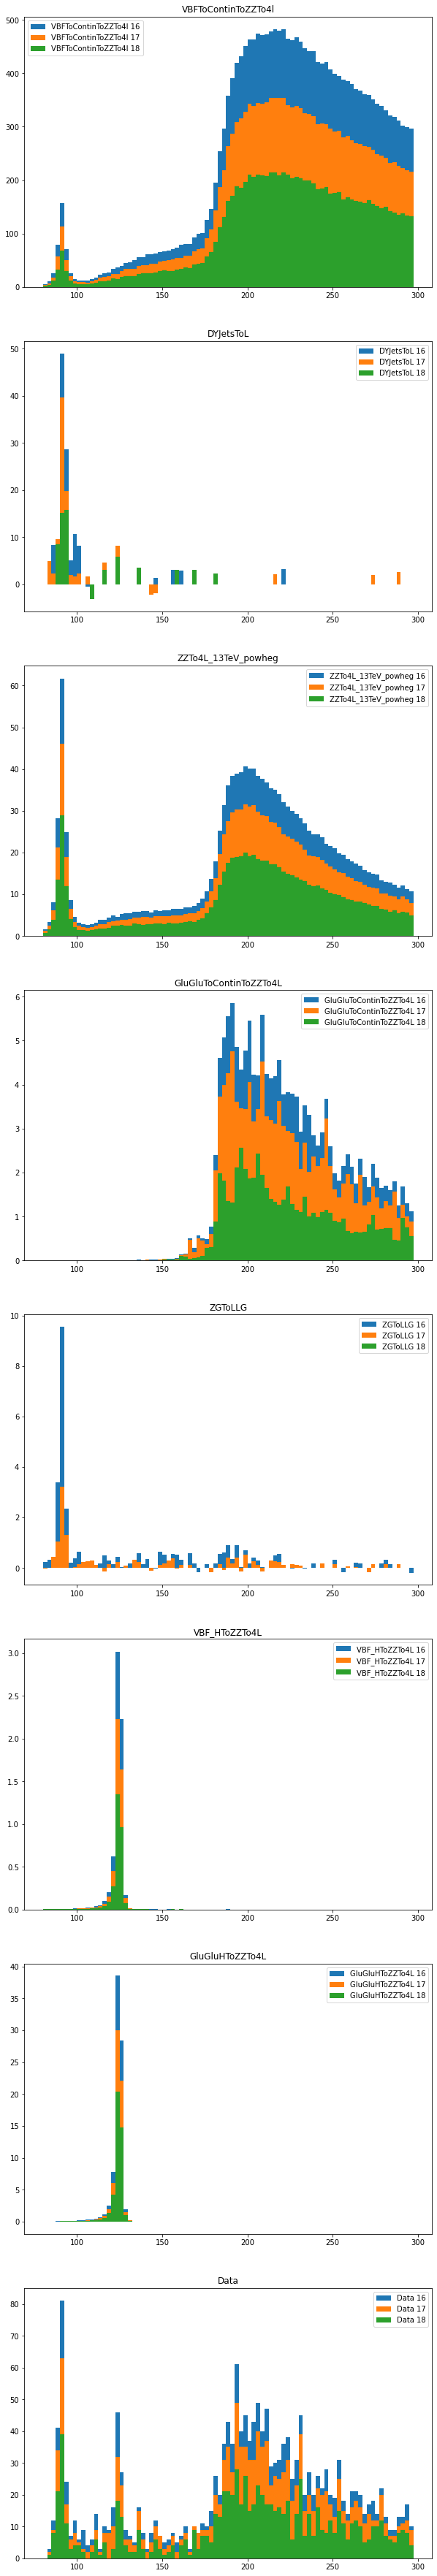

In [14]:
# fileread = FileRead(num_tag = "0107_2")
higgs_output.histogram_by_process_by_year()
plt.show()

## Bined couts by lepton flavor

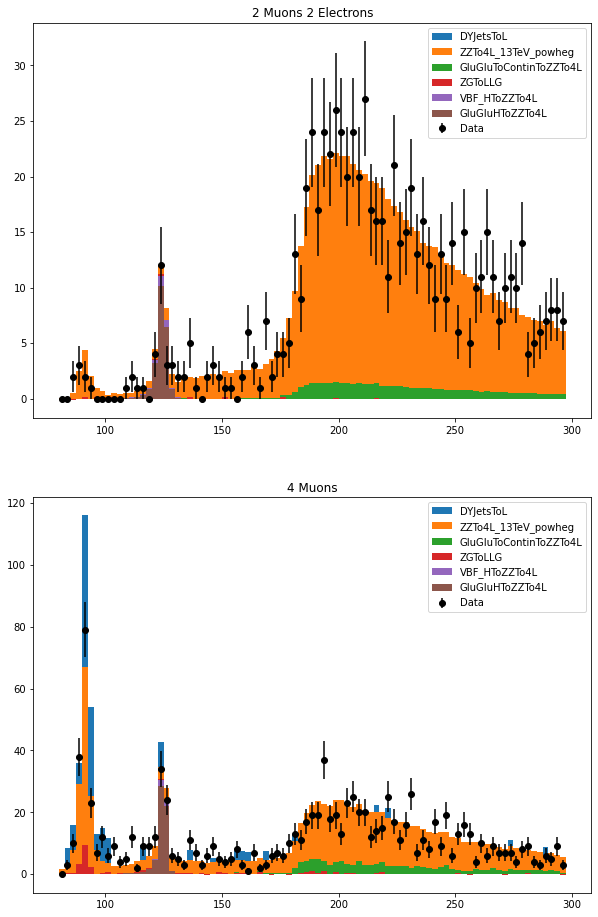

In [34]:
higgs_output.histogram_by_group_by_process(divide_first_pair=False)

## Total by process

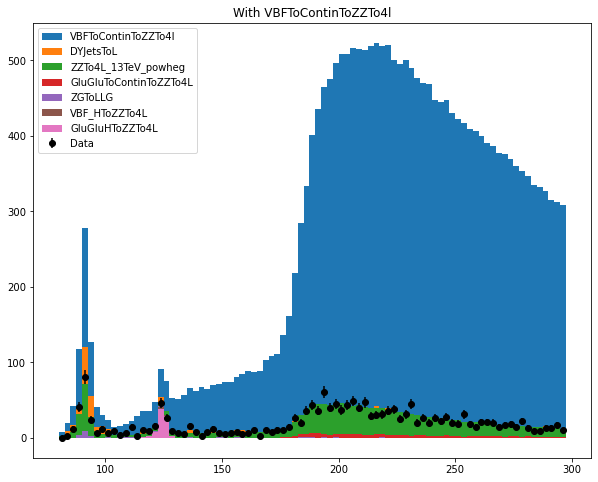

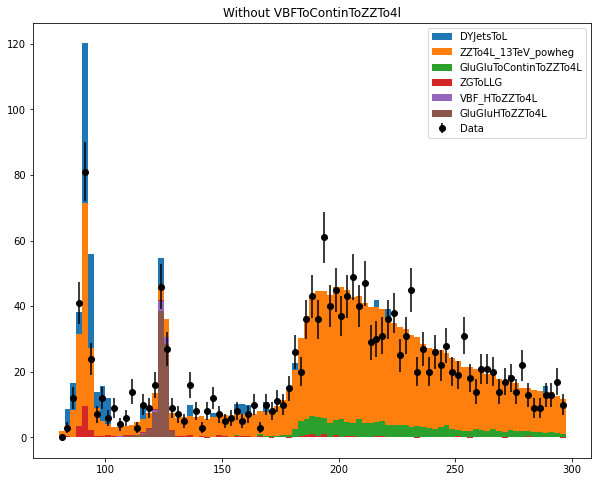

In [35]:
higgs_output.histogram_by_process()

# Statistical analysis

The following procedure is a simplification of the full hypothesis test gathered from the CMS - NOTE 2011-005. The CMS - NOTE 2011-005 describes the statistical approach used to determine whether the Higgs boson mass value found from the data from the particle collider, originates from an actual signal in combination with background noise, or if it is simply due to only background noise. 

The statistical procedure with the choice of the test statistics is summarised below,

1. Construct the likelihood function
$$\mathcal{L}\left(\mbox{data}|\mu,\theta\right) = \mbox{Poisson}\left(\mbox{data}|\mu \cdot s\left(\theta\right) + b\left(\theta\right)\right)\cdot p\left(\tilde{\theta}|\theta\right)$$

* Data represents either actual experimental observation or pseudo-data used to construct sampling distributions

* $\mu$ is the signal strength modifier and $\theta$ represents the full suite of nuiance parameters

* Poissons(data|$\mu s + b$) stands for a product of Poisson probabilities to observe $n_i$ events in bins $i$:
$$\prod_{i} \frac{\left(\mu s_i + b_i\right)^{n_i}}{n_i !} e^{-\mu s_i - b_i}$$

2. To compare the compability of the data with the background -only and signal + background hypothesis, the test statistic $\tilde{q_{\mu}} $ is used: $$\tilde{q_{\mu}} =  - 2\ln \frac{\mathcal{L}\left(\mbox{data}|\mu, \hat{\theta_{\mu}}\right)}{\mathcal{L}\left(\mbox{data}|\hat{\mu}, \hat{\theta}\right)},$$  
with $0 \leq \hat{\mu} \leq \mu$, and $\hat{\mu}$ and $\hat{\theta}$ are the values that corresponds to the global maximum of the likelihood.

3. Compute $\tilde{q_{\mu}}^{obs}$, $\hat{\theta_{\mu}}^{obs}$, $\hat{\theta_{0}}^{obs}$ for the $\mu$ value tested.

4. Generate toy Monte Carlo pseudo-data to construct pdfs $f\left(\tilde{q_{\mu}}|\mu, \hat{\theta_{\mu}}^{obs}\right)$ and $f\left(\tilde{q_{\mu}}|0, \hat{\theta_{0}}^{obs}\right)$ assuming a signal with strength $\mu$ in the signal+background hypothesis and for the background-only hypothesis ($\mu$ = 0).

5. Having constructed $f\left(\tilde{q_{\mu}}|\mu, \hat{\theta_{\mu}}^{obs}\right)$ and $f\left(\tilde{q_{\mu}}|0, \hat{\theta_{0}}^{obs}\right)$ distributions, define two p-values to be associated with the actual observation for the signal + background and background-only hypothesis, $p_{\mu}$ and $p_b$:
$$p_{\mu} = P\left(\tilde{q_{\mu}} \geq \tilde{q}_{\mu}^{obs}|\mbox{signal + background}\right) = \int_{\tilde{q}_{\mu}^{obs}}^{\infty} f\left(\tilde{q}_{\mu}|\mu, \hat{\theta_{\mu}}^{obs}\right) d\tilde{q_{\mu}} $$

$$1- p_{b} = P\left(\tilde{q_{\mu}} \geq \tilde{q}_{\mu}^{obs}|\mbox{background only}\right) = \int_{\tilde{q}_{\mu}^{obs}}^{\infty} f\left(\tilde{q}_{\mu}|0, \hat{\theta_{0}}^{obs}\right) d\tilde{q_{\mu}}$$

and calculate $CL_{s}\left(\mu\right) = \frac{p_{\mu}}{1-p_{b}}$.

6. To quote the 95$\%$ Confidence Level upper limit on $\mu$, to be further denoted as $\mu^{95\%CL}$ we adjust $\mu$ until we reach $CL_s = 0.05$ and we would state that the SM Higgs boson is excluded with 95$\%$ Confidence Level.




## Importing necessary packages

In general the statistical procedure has been implemented by using arrays, lists and statistical functions. No additional pre-made packages were used, as we wanted to gain insight in the actual steps of the procedure. However, the package pyhf was used to check the results of our own method in the beginning to make sure we had implemented some of the functions correctly.

## Uploading data and checking the correspondence between data and simulations

The data has been processed to collect all events of 2 muon pairs or a muon pair coupled with an electron pair, as these are considered indicators of a Higgs-boson having decayed to a Z-boson pair. Only pairs with m>100 GeV has been considered.

In [36]:
# Loading data
(
    bin_counts,
    true_counts,
    sim_signal_counts,
    sim_background_counts,
) = higgs_output.load_binned_counts()

To visualize the correspondence between the real data and the simulations, the counts of the simulated data and the real data
are plotted together in an histogram. The simulated signal is plotted in red, the simulated background in blue, and the counts of the real data has been added in black on top. As one can see, the findings of the simulated and the real data correspond quite well.

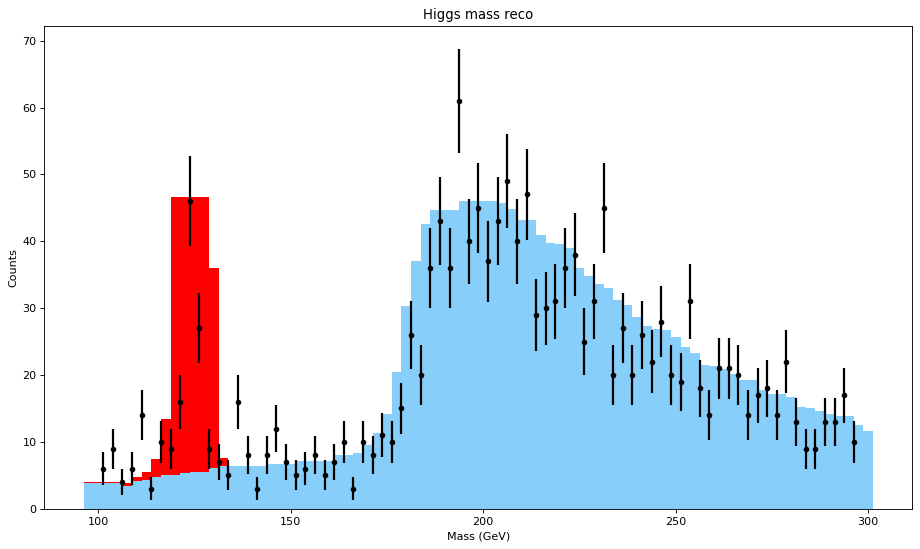

In [37]:
figure(figsize=(14, 8), dpi=80)
width = 10

bincenters = (bin_counts[1:] + bin_counts[:-1]) / 2

plt.errorbar(
    bincenters,
    true_counts,
    yerr=np.sqrt(true_counts),
    markersize=8,
    fmt=".",
    color="black",
    linewidth=2,
)
plt.bar(
    bincenters[
        0:,
    ],
    sim_background_counts + sim_signal_counts,
    color="red",
    alpha=1,
    width=width,
)
plt.bar(
    bincenters[
        0:,
    ],
    sim_background_counts,
    color="lightskyblue",
    alpha=1,
    width=width,
)
plt.title("Higgs mass reco")
plt.xlabel("Mass (GeV)")
plt.ylabel("Counts")
plt.show()

## Defining necessary functions

In order to proceed with the statistical analysis of the data, we must define and implement the likelihood-function

$$\mathcal{L}\left(\mbox{data}|\mu,\theta\right) = \mbox{Poisson}\left(\mbox{data}|\mu \cdot s\left(\theta\right) + b\left(\theta\right)\right)\cdot p\left(\tilde{\theta}|\theta\right)$$

and the test statistic $$\tilde{q_{\mu}} =  - 2\ln \frac{\mathcal{L}\left(\mbox{data}|\mu, \hat{\theta_{\mu}}\right)}{\mathcal{L}\left(\mbox{data}|\hat{\mu}, \hat{\theta}\right)},$$ 

In addition the functions for generating toy data are defined by using scipy.stats, and a function to gather the value of $\mu$ that maximizes the likelihood-function for a given set of data. The latter was done by using scipy.optimize.minimize to find the minimum of the log.likelihood function multiplied by -1.

In [38]:
# We can assume the data we are getting in is an array of discrete counts;
# The likelihood function for each bin is given by the poisson distribution
# pmf(k, mu, loc=0)

# log of likelihood function to avoid underflow


def log_likelihood(params, s=sim_signal_counts, b=sim_background_counts, n=true_counts):
    """
    params[0] = signal strength parameter mu
    params[1] = nuisance parameter theta
    s         = number of expected signal events in bin i
    b         = number of expected background events in bin i
    n         = number of real events in bin i
    """

    nu = (params[0] * s) + b
    log_poiss_pdf = sum(np.log(ss.poisson.pmf(n, nu)))
    theta_pdf = ss.norm.pdf(x=params[1], loc=0, scale=0.15)

    return log_poiss_pdf + np.log(theta_pdf)


# we construct the test statistic q ̃_mu based on the profile likelihood ratio:


def q_tilde_mu(
    mu_1,
    theta1,
    mu_2,
    theta2,
    n=true_counts,
    s=sim_signal_counts,
    b=sim_background_counts,
    func=log_likelihood,
):

    log_val = func([mu_1, theta1], s, b, n) - func([mu_2, theta2], s, b, n)

    return -2 * log_val


# Functions for generating toy Monte Carlo pseudo-data to
# construct pdfs f(q^~_μ |μ) and f (q^ ̃_μ |0 )
# assuming a signal with strength μ in the signal+background
# hypothesis and for the
# background-only hypothesis (μ = 0).


def create_toy(mu, s, b):
    """
    Return a random Poisson distributed value
    with mu*s + b as its expected value
    """

    return ss.poisson.rvs((mu * s) + b, size=1)


def create_toy_distr(mu, s, b, func=create_toy):

    """
    Generate for each bin a random Poisson
    distributed values in according to the
    counts for simulated signal and background
    """

    toys_list = np.zeros(len(s))
    for i in range(len(s)):
        toys_list[i] = func(mu, s[i], b[i])

    return toys_list


# loop over all the different toy-datasets
# and calculate the optimal mu for each of them


def get_params_max(df, s, b):

    n_toys = len(df.iloc[:, 0])
    mu_s = np.zeros(n_toys)
    thets_s = np.zeros(n_toys)

    for i in range(n_toys):
        fun = lambda x: -log_likelihood(x, s, b, n=df.iloc[i, :])
        params_opt_i = sp.optimize.minimize(fun, (0.5, 0.5), bounds=((0, 1), (-5, 5)))
        mu_s[i], thets_s[i] = params_opt_i["x"]

    return mu_s, thets_s

# Analysis

### Finding $\hat{\mu}$ of our original data

First we must find $\hat{\mu}$ and $\hat{\theta}$ the value that maximize the likelihood function for our original data, where $\mu \in [0,1]$.

In [39]:
fun = lambda x: -log_likelihood(x)

params_opt = sp.optimize.minimize(fun, (0.5, 0.5), bounds=((0, 1), (-1, 1)))

mu_max, theta_max = params_opt["x"]

print("The best fit value of mu for our original data is: ", mu_max)
print("The best fit value of theta for our original data is: ", theta_max)

mu = np.linspace(1, 0.01, 100)
theta = np.linspace(-1, 1, 100)


likelihood_val = np.zeros((len(mu), len(theta)))

for i in range(len(mu)):
    for j in range(len(theta)):
        Z = log_likelihood([mu[i], theta[j]])

        likelihood_val[i][j] = Z

The best fit value of mu for our original data is:  0.9571142401168382
The best fit value of theta for our original data is:  -4.4375820820017163e-07


Doing this, we find that the value of $\mu$ that maximizes the likelihood function for our original dataset is $\hat{\mu}=0.957$. This means the likelihood -function is maximized with the presence of a strong signal. This can be visualized in a 3D-plot, showing the peak of our likelihood-function.

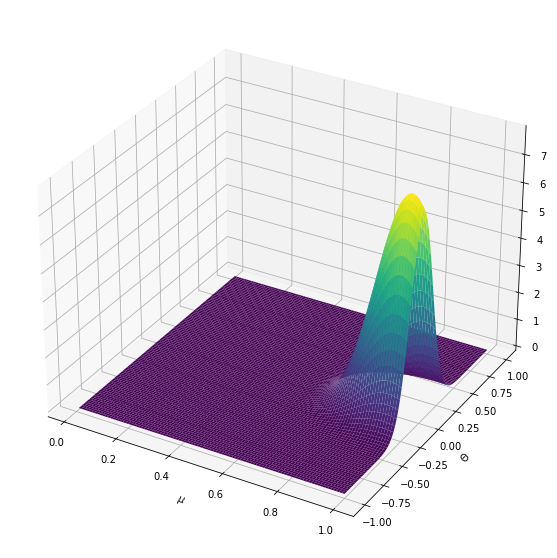

In [40]:
X, Y = np.meshgrid(theta, mu)

fig = plt.figure(figsize=(15, 10))

ax = plt.axes(projection="3d", label="z")

ax.plot_surface(
    Y, X, np.exp(likelihood_val), rstride=1, cstride=1, cmap="viridis", edgecolor="none"
)
ax.set_xlabel("$\mu$")
ax.set_ylabel("$\Theta$")
plt.show()

## Costructing the pdf of $ \tilde{q}_{\mu} $ generating toy pseudo-data

Moving on, we need to construct the pdf's of our test-statistc $\tilde{q}_{\mu}$. The range for $\mu$ is 100 values in the interval $[0,1]$. For each chosen value of $\mu$, 4000 data-toys are generated by drawing from a poisson distribution with $\lambda = s \cdot \mu + b$, where $s$ and $b$ are the simulated signal and- background data respectively. For each value of $\mu$, the test-statistic $\tilde{q}_{\mu}^{obs}$ is calculated under the signal+background and for the background-only hypothesis from the generated toy-data. These become our distributions for $\tilde{q}_{\mu}$ under the signal+background and for the background-only hypothesis, respectively $f\left(\tilde{q_{\mu}}|\mu, \hat{\theta_{\mu}}^{obs}\right)$,
$f\left(\tilde{q_{\mu}}|0, \hat{\theta_{0}}^{obs}\right)$ .

In [22]:
# Find Theta_0_max obs and Theta_mu_max obs:

fun    = lambda x:  - log_likelihood([0,x])
theta_0_obs  = sp.optimize.minimize(fun, 0.5, bounds=((-1, 1),))["x"]

theta_mu_obs = []
for i in mu:
    fun    = lambda x:  - log_likelihood([i,x])
    theta_mu_obs.append(sp.optimize.minimize(fun, 0.5, bounds=((-1, 1),))["x"])


In [437]:
n = len(mu)
N = 4000
q_tilde_obs = np.zeros(n)
q_0_toy     = np.zeros([N,n])
q_mu_toy    = np.zeros([N,n])

for i in range(n):

    q_tilde_obs[i] = q_tilde_mu(mu[i], theta_mu_obs[i], mu_max, theta_max, true_counts)
    
    for j in range(N):
        
        # toy data for bkg hypothesis and signal hypothesis
        toys0 = pd.DataFrame(create_toy_distr(0,sim_signal_counts, sim_background_counts)).T
        toysmu = pd.DataFrame(create_toy_distr(mu[i],sim_signal_counts, sim_background_counts)).T
        
        # get mu and theta that maximize the likelihood computed on the toy data
        mu_s_0, theta_s_0    = get_params_max(toys0,sim_signal_counts, sim_background_counts)
        mu_s_mu, theta_s_mu  = get_params_max(toysmu,sim_signal_counts, sim_background_counts)
        
        # saving
        q_0_toy[j][i]  = q_tilde_mu(mu[i],theta_0_obs,  mu_s_0, theta_s_0, toys0.iloc[0,:])
        q_mu_toy[j][i] = q_tilde_mu(mu[i],theta_mu_obs[i], mu_s_mu, theta_s_mu, toysmu.iloc[0,:])


In [438]:
## SAVING
q_tilde_obs_frame = pd.DataFrame(q_tilde_obs)
q_0_toys_frame = pd.DataFrame(q_0_toy)
q_mu_toys_frame = pd.DataFrame(q_mu_toy)

q_tilde_obs_frame.to_csv("q_tilde_obs_N_4000.csv")
q_0_toys_frame.to_csv("q_0_toys_N_4000.csv")
q_mu_toys_frame.to_csv("q_mu_toys_N_4000.csv")

In [23]:
## UPLOADING THE NEW FILES
q_tilde_obs = pd.read_csv("q_tilde_obs_N_4000.csv")
q_0_toys = pd.read_csv("q_0_toys_N_4000.csv")
q_mu_toys = pd.read_csv("q_mu_toys_N_4000.csv")

# remove indexes
q_mu_toys = q_mu_toys.iloc[:,1:]
q_0_toys = q_0_toys.iloc[:,1:]
q_tilde_obs = q_tilde_obs.iloc[:,1:]


### Finding the $CL_{s}\left(\mu\right)$ value giving $\mu^{95\%CL}$

Having constructed $f\left(\tilde{q_{\mu}}|\mu\right)$ and $f\left(\tilde{q_{\mu}}|0\right)$ distributions, we define two p-values to be associated with the actual observation for the signal + background and background-only hypothesis, $p_{\mu}$ and $p_b$:
$$p_{\mu} = P\left(\tilde{q_{\mu}} \geq \tilde{q}_{\mu}^{obs}|\mbox{signal + background}\right) = \int_{\tilde{q}_{\mu}^{obs}}^{infty} f\left(\tilde{q}_{\mu}|\mu, \hat{\theta_{\mu}}^{obs}\right) d\tilde{q_{\mu}} $$

$$1- p_{b} = P\left(\tilde{q_{\mu}} \geq \tilde{q}_{\mu}^{obs}|\mbox{background only}\right) = \int_{\tilde{q}_{\mu}^{obs}}^{infty} f\left(\tilde{q}_{\mu}|0, \hat{\theta_{0}}^{obs}\right) d\tilde{q_{\mu}}$$

and calculate $CL_{s}\left(\mu\right) = \frac{p_{\mu}}{1-p_{b}}$. The p-value $p_{\mu}$ tell us the probability that the test-statistic $q$ would be larger or equal to the observed value $q_{\mu}^{obs}$, for a given value of signal strength $\mu$, while $p_{b}$ tell us the probability that we would observe the same value for $q_{\mu}^{obs}$ or something more extreme, given that we had only background noise and no signal. The $CL_{s}\left(\mu\right)$ is given as the ratio between the two. We calculate these integrals by summarizing the number of counts in each bin multiplied with it's binwidth, until we find $CL_{s}\left(\mu\right) = 0.05$, and collect what value of $\mu$ this corresponds to. Doing this, we find that it corresponds to a value of $\mu = 0.75$. This means, that as long as the value of $\mu$ observed in our data is larger than 0.75, we should be able to keep our hypothesis of a signal.

In [94]:
CLs_val = []
mu_     = []
mu_95   = 0
CLs_95  = 0

for i in range(len(mu)):
    
    #i = len(mu) - j -1 #scanning mu from mu = 1 
    counts_mu, bins_mu = np.histogram(q_mu_toys.iloc[:,i], bins=np.arange(300), density=True)
    counts_0, bins_0   = np.histogram(q_0_toys.iloc[:,i],  bins=np.arange(300), density=True)

    bin_width = bins_mu[1]-bins_mu[0]

    bincenters_mu = bins_mu[:len(bins_mu)-1] + (bin_width/2)
    bincenters_0  = bins_0[:len(bins_0)-1] + (bin_width/2)
    
    counts_mu_q = counts_mu[bincenters_mu >= q_tilde_obs.iloc[i,:][0]]
    counts_0_q  = counts_0[bincenters_0 >= q_tilde_obs.iloc[i,:][0]]
    
    p_val_mu    = sum( bin_width*counts_mu_q )
    not_p_val_b = sum( bin_width*counts_0_q)
    
    if (not_p_val_b):
        CLs = p_val_mu/not_p_val_b
        CLs_val.append(CLs)
        mu_.append(mu[i])
        while(CLs >= 0.05):
            mu_95 = mu[i]
            CLs_95 = CLs_val[i]
            CLs = 0


In [95]:
print(r"Our estimation for the 95% Confidence Level upper limit on μ is :", mu_95)

Our estimation for the 95% Confidence Level upper limit on μ is : 0.75


Below is the plotted curve of $CL_{s}\left(\mu\right)$ showing the value of $\mu$ corresponding to $CL_{s}\left(\mu\right) \approx 0.05$.

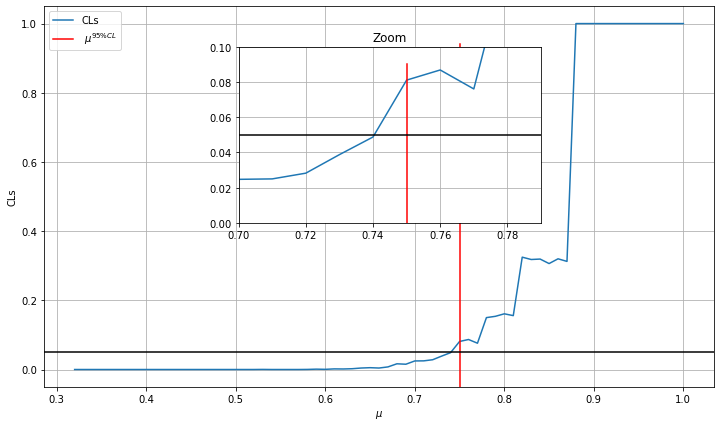

In [113]:
fig,ax = plt.subplots(figsize=(12,7))
ax.plot( mu_, CLs_val, label = 'CLs')
ax.axvline(x = mu_95, ymin = 0.0, ymax = 0.9, c = 'red', label = ' $\mu^{95\%CL}$')
ax.axhline(y = 0.05, c = 'black')
ax.set_xlabel('$\mu$')
ax.set_ylabel('CLs')
ax.legend()
ax.grid()

axes1 = plt.axes( [0.35, 0.45, 0.35, 0.35] )
axes1.set_title( 'Zoom' )
axes1.plot( mu_, CLs_val)
axes1.set_ylim(0,0.1)
axes1.set_xlim(0.70,0.79)
axes1.axvline(x = mu_95, ymin = 0.0, ymax = 0.9, c = 'red')
axes1.axhline(y = 0.05, c = 'black')
axes1.grid()

In [102]:
print('As we have a discrete variable μ we choose for the upper \
limit the value that provide the nearest value of CLs to 0.05 that is', round(CLs_95, 3))

As we have a discrete variable μ we choose for the upper limit the value that provide the nearest value of CLs to 0.05 that is 0.081


## Histogram representation of toy distributions for $\tilde{q}_{\mu}$

The two histograms for the signal and background hypothesis for the upper limit value of $\mu$, $\mu^{95\%CL}$ are plotted below. From the plot one can see that the histrograms are not overlapping at all, indicating that our data has a good resolution. This can be interpreted as our data showing a clear signal, as the distributions for a signal and no signal are clearly separated.

In [104]:
index_mu_95 = np.where(mu == mu_95)[0][0]
q_0_distr  = q_0_toys.iloc[:,index_mu_95]
q_mu_distr = q_mu_toys.iloc[:,index_mu_95]

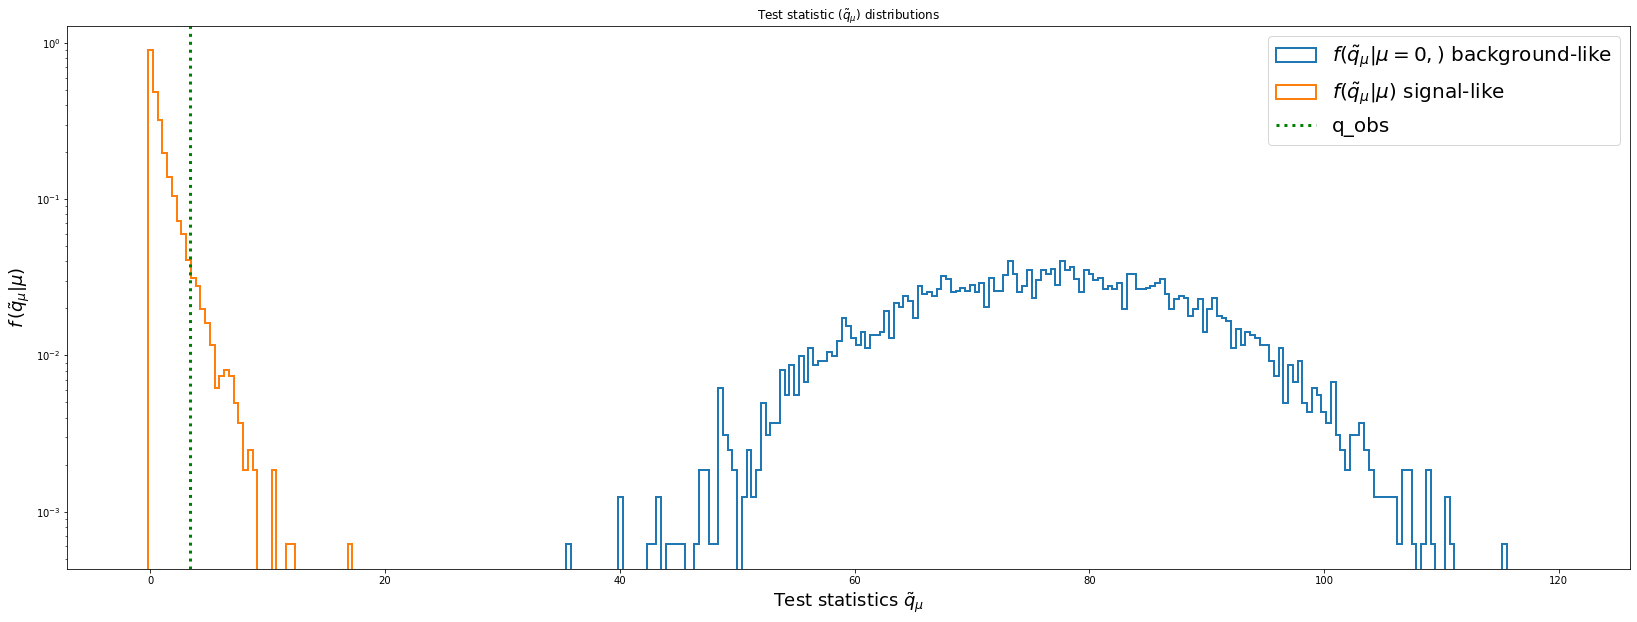

In [111]:
fig, ax = plt.subplots(1,1, figsize=(28,10))

bins = np.linspace(-1, 120, 300)

histogram_0 = ax.hist(q_0_distr, 
                       bins = bins,
                       histtype = 'step',
                       facecolor='c', 
                       density=True,
                       label=r"$f(\tilde{q}_{\mu }|\mu = 0, )$ background-like",
                       linewidth=2)

histogram_1 = ax.hist(q_mu_distr,
                       bins  = bins,
                       histtype = 'step',
                       facecolor='c',
                       density=True,
                       label =r"$f(\tilde{q}_{\mu }|\mu )$ signal-like",
                       linewidth=2)            

ax.axvline(q_tilde_obs.iloc[index_mu_95,:][0], color='green', linestyle='dotted', linewidth=3, label = "q_obs")
ax.set_yscale('log')
ax.set_xlabel(r"Test statistics $\tilde{q}_{\mu}$", fontsize=18)
ax.set_ylabel(r"$f\,(\tilde{q}_{\mu}|\mu)$", fontsize=18)
ax.set_title(r"Test statistic $(\tilde{q}_{\mu})$ distributions")
ax.legend(prop={'size': 20})


## Significance of an excess of events

The presence of the signal is quantified by the background-only p-value, i.e. the probability for the background to fluctuate and give an excess of events as large or larger than the observed one. As before, this requires defining a test statistic and the construction of its sampling distribution. For a given Higgs boson mass hypothesis, the test statistic used is $q_0$.

$$\tilde{q_0} =  - 2ln \frac{\mathcal{L}\left(\mbox{data}|0, \hat{\theta_{0}}\right)}{\mathcal{L}\left(\mbox{data}|\hat{\mu}, \hat{\theta}\right)},$$ 

It must be shown that the probability of collecting a signal with only backround noise is small enough to discard this hypothesis. In order to do so, we must integrate the pdf of $q_0$. This has been done by approximating the histogram with an exponential function and taking the integral of it. However, it was hard to obtain a perfect fit, which causes our approxiamtion to fully incorporate the intire histogram. However, it was found sufficient to give a good enough approximation for our p-value.

In [16]:
N      = 10**5
q_0_0s = np.zeros(N*10)

In [51]:
for i in tqdm(range(N*5)):
    toy_count0 = create_toy_distr(0, sim_signal_counts, sim_background_counts)
    
    fun0      = lambda x: -log_likelihood(x,
                                          sim_signal_counts,
                                          sim_background_counts,
                                          toy_count0) 

    
    params = sp.optimize.minimize(fun0,(0.5, 0.5),bounds=((0,1),(-1,1)))["x"]
    mu_s_0    = params[0]
    theta_s_0 = params[1]
    
    q_0_0s[i+(N*5)]   = q_tilde_mu(0, theta_0_obs, mu_s_0, theta_s_0, toy_count0)


100%|███████████████████████████████████████████████████████████| 500000/500000 [2:18:33<00:00, 60.14it/s]


In [89]:
%%cpp
TH1F *h = new TH1F("h", "h", 750, 3, 18); 
ifstream inp; 
double x; 
inp.open("q0_sample.txt"); 
while(!(inp >> x)==0){h->Fill(x);} 
// Double_t factor = 1.;
// h->Scale(factor/h->GetEntries());
TF1 f( "exp fit","expo");
h->Fit(&f);

 FCN=605.812 FROM MIGRAD    STATUS=CONVERGED      71 CALLS          72 TOTAL
                     EDM=4.17702e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     7.96444e+00   1.61675e-02   6.21813e-05   5.18210e-03
   2  Slope       -6.12061e-01   3.31455e-03   1.27478e-05   2.06764e-02


Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


In [90]:
def expo(x, a= 7.96e+00 , b = -6.12e-01):
    return np.exp( a + b*x )

x = np.linspace(1, 190, 10000)
y = expo(x)

In [91]:
q_0_0s = []
with open( 'q0_sample.txt', 'r' ) as in_file:
    for line in in_file:
        for q_0_0 in line.split( ): 
            q_0_0s.append( float(q_0_0) )


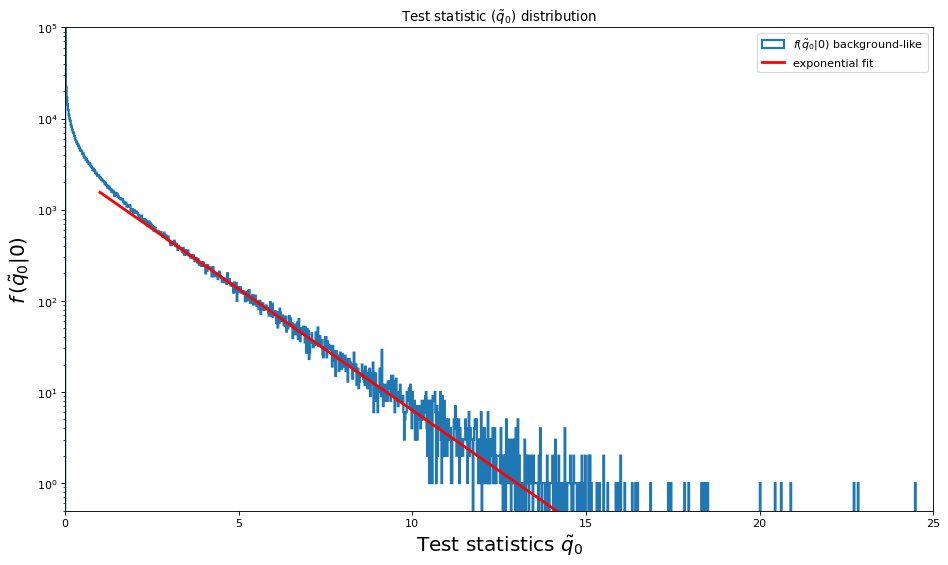

In [93]:
figure(figsize=(14, 8), dpi=80)
histogram_0 = plt.hist(q_0_0s, 
                       bins = 1250,
                       histtype = 'step',
                       facecolor='c', 
                       #density=True,
                       label=r"$f(\tilde{q}_0|0)$ background-like",
                       linewidth=2)


plt.plot(x, y, color = 'red', linewidth=2.5, label=r"exponential fit")

plt.xlabel(r"Test statistics $\tilde{q}_{0}$", fontsize=18)
plt.ylabel(r"$f\,(\tilde{q}_{0}|0)$", fontsize=18)
plt.title(r"Test statistic $(\tilde{q}_{0})$ distribution")
plt.yscale('log')
plt.ylim(0.5,100000)
plt.xlim(0,25)
plt.legend()

Now we can compute 
$$p_{0} = P\left(\tilde{q_{0}} \geq \tilde{q}_{0}^{obs}|\mbox{signal + background}\right) = \int_{\tilde{q}_{0}^{obs}}^{infty} f\left(\tilde{q}_{0}| 0,  \hat{\theta_{0}}^{obs} \right) dq_{0} $$

In [80]:
# Finding q0_obs as ratio of Likelihood-functions with mu = 0 and mu = best fit 
q_obs_0 = q_tilde_mu(0, theta_0_obs, mu_max, theta_max)
print("q_obs_0: ",q_obs_0)

q_obs_0:  [188.46005869]


In [81]:
# p-value computed integrating analitically the function that fit the distribution above
i       = integrate.quad(expo, 0 , np.inf)[0]
p_val_0 = integrate.quad(expo, q_obs_0 ,np.inf)[0]
p_val_0/i

2.621304514006636e-26

$\tilde{q}_{0}^{obs}$ is found to be above 188, which is far ourside the region of our distribution. Hence, the value $p_{0}$ we found for distribution is very small. It is smaller than expected, but we assume that is due to the clearly defined signal in our data, and the fact that our statistical treatment is somewhat simplified.

### Final result, cross section

As a last part of the project, we aimed to find the cros section of our interaction. 

    Fit of the peak: Gaussian 
    Fit for the bkg: a+bx

In [114]:
%%cpp

const int n_points =25;
double x_vals [ n_points ]={ 101.25, 103.75, 106.25, 108.75, 111.25, 113.75, 116.25, 118.75, 121.25, 123.75, 126.25, 128.75, 131.25, 133.75, 136.25, 138.75, 141.25, 143.75, 146.25, 148.75, 151.25, 153.75, 156.25, 158.75,161.25 };
double y_vals [ n_points ]={ 6.,  9.,  4.,  6., 14.,  3., 10.,  9., 16., 46., 27.,  9.,  7., 5., 16.,  8.,  3.,  8., 12.,  7.,  5.,  6.,  8.,  5.,  7. };
double y_errs [ n_points ]={ 2.45, 3., 2., 2.45, 3.74, 1.73, 3.16, 3., 4., 6.7, 5.20, 3., 2.65, 2.24, 4., 2.83, 1.73, 2.83, 3.46, 2.65, 2.24, 2.45, 2.83, 2.24, 2.65};
TGraphErrors graph(n_points ,x_vals , y_vals, NULL, y_errs ) ;
TF1 f( "PeakFit" , "gaus + [3] + [4]*x " , 100 , 160  ) ;
PeakFit->SetParameter(0, 1);
PeakFit->SetParameter(1, 127);
PeakFit->SetParameter(2, 1.65675);
//PeakFit->SetParameter(3, 1 );
//PeakFit->SetParameter(4, 0);

graph.Fit(&f);


 FCN=26.6431 FROM MIGRAD    STATUS=CONVERGED     379 CALLS         380 TOTAL
                     EDM=2.79018e-07    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   2.7 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           4.00234e+01   6.97896e+00   8.60362e-02  -2.08797e-05
   2  p1           1.24224e+02   2.72162e-01  -1.05557e-03  -2.22875e-03
   3  p2           1.82874e+00   2.84193e-01  -2.13590e-03  -2.46538e-03
   4  p3           5.41362e+00   3.72968e+00  -3.29395e-04   4.88487e-04
   5  p4           6.29988e-03   2.78879e-02  -1.43362e-05   6.52291e-02


In [115]:
# fit only the peak
Mass  = 1.24224e+02 
sigma = 1.82884e+00
N =  4.00234e+01
a =  5.41362e+00
b = 6.29988e-03
def fit_function_real( x, N = N, mu = Mass, sigma = sigma):
    return ( N*np.exp( -( x - mu )**2/( 2*sigma**2 )))

In [116]:
#N = 2.5*(sum(true_counts[6:13]))/(sigma*np.sqrt(2*np.pi))
def fit_function( x, N = N, mu = Mass, sigma = sigma, a = a, b = b):
    return ( N*np.exp( -( x - mu )**2/( 2*sigma**2 ))) + a + b*x

x = np.linspace(100, 160, 1000)
total_fit = fit_function(x)

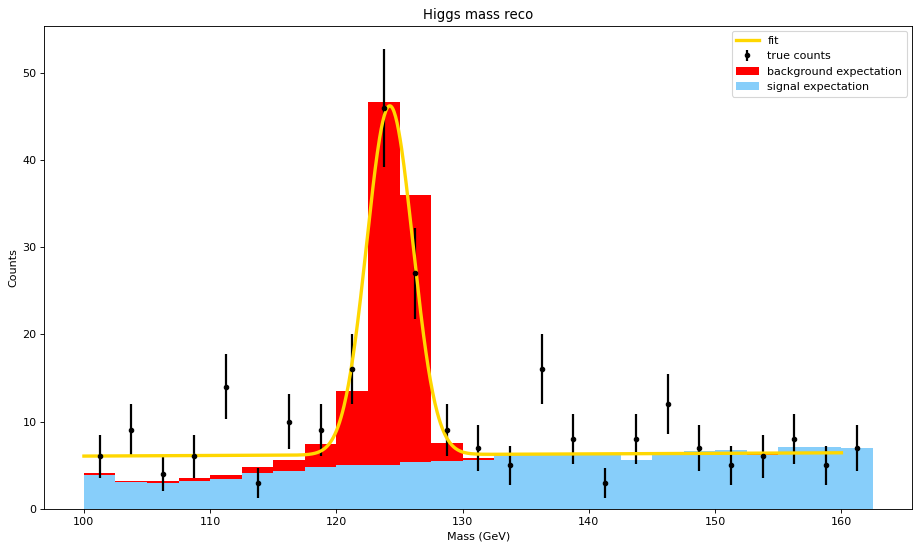

In [118]:
figure(figsize=(14, 8), dpi=80)

width      = [bin_counts[1] - bin_counts[0]]
bincenters = ( bin_counts[1:] + bin_counts[:-1]  ) / 2

plt.errorbar( bincenters[0:25], true_counts[0:25],
              yerr   = np.sqrt(true_counts[0:25]),
              markersize  = 8,
              fmt    = '.', 
              color  = 'black',
              linewidth = 2,
              label = 'true counts')

plt.bar(bincenters[0:25], sim_background_counts[0:25] + sim_signal_counts[0:25] , 
        color = 'red', alpha = 1, 
        width = width, label = 'background expectation'  )
plt.bar(bincenters[0:25], sim_background_counts[0:25] , 
        color = 'lightskyblue', alpha = 1, 
        width = width, label = 'signal expectation' )
plt.plot(x, total_fit, linewidth = 3, color ='gold', label = 'fit')
#ax.axvline(125.203, color='green', linestyle='dotted', linewidth=3, label = "q_obs")
#plt.grid()
plt.title("Higgs mass reco")
plt.xlabel("Mass (GeV)")
plt.ylabel("Counts")
plt.legend()

The fit provides the following estimation of the Higgs boson mass: 

m = $(124.2 \pm 0.3) GeV / c^2$

We perform the ratio between the area of the real data and the Monte Carlo simulation that should be equal to the experimental cross section normalized to the standard model cross section.

In [190]:
# fit the montecarlo signal peak

In [183]:
%%cpp
const int n_points =25;
double x_vals [ n_points ]={ 101.25, 103.75, 106.25, 108.75, 111.25, 113.75, 116.25, 118.75, 121.25, 123.75, 126.25, 128.75, 131.25, 133.75, 136.25, 138.75, 141.25, 143.75, 146.25, 148.75, 151.25, 153.75, 156.25, 158.75,161.25 };
double y_vals [ n_points ]={ 1.72527502e-01, 1.86151292e-01, 2.92355932e-01, 3.57908321e-01,
       4.66617711e-01, 7.15619011e-01, 1.25526479e+00, 2.65779862e+00,
       8.44184432e+00, 4.15429615e+01, 3.06647317e+01, 2.06958001e+00,
       2.11844903e-01, 4.08810976e-02, 1.23924608e-02, 9.12151281e-03,
       8.16222315e-03, 4.44599265e-03, 3.55434332e-03, 5.49285594e-03,
       5.50392750e-03, 6.91309361e-03, 2.03720787e-03, 2.39548055e-04}; 
double y_errs [ n_points ]={ 0.4153643 , 0.43145254, 0.54069948, 0.59825439, 0.68309422,
       0.84594268, 1.120386  , 1.63027563, 2.90548521, 6.44538296,
       5.53757453, 1.43860349, 0.46026612, 0.20219075, 0.11132143,
       0.09550661, 0.09034502, 0.06667828, 0.05961831, 0.0741138 ,
       0.07418846, 0.08314502, 0.04513544, 0.01547734, 0.04533976};

TGraphErrors graph(n_points ,x_vals , y_vals, NULL, y_errs ) ;
TF1 f( "PeakFit" , "gaus" , 100 , 160  ) ;
PeakFit->SetParameter(0, 1);
PeakFit->SetParameter(1, 125);
PeakFit->SetParameter(2, 1.65675);
//PeakFit->SetParameter(3, 1 );
//PeakFit->SetParameter(4, 0);

graph.Fit(&f);

 FCN=6.20523 FROM MIGRAD    STATUS=CONVERGED     108 CALLS         109 TOTAL
                     EDM=1.36773e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     4.69209e+01   6.50926e+00   6.75258e-03  -2.24944e-06
   2  Mean         1.24513e+02   1.99745e-01   2.53626e-04   2.56217e-04
   3  Sigma        1.76280e+00   1.49249e-01   2.05740e-05  -4.06720e-04


In [121]:
Mass_sim  =  1.24513e+02
sigma_sim =  1.76280e+00
N_sim     =  4.69209e+01
def fit_function_sim( x, N = N_sim, mu = Mass_sim, sigma = sigma_sim):
    return ( N*np.exp( -( x - mu )**2/( 2*sigma**2 )))

In [122]:
# integral of real signal
real = integrate.quad(fit_function_real, 100, np.inf)[0]
# integral of sim signal
sim = integrate.quad(fit_function_sim, 100, np.inf)[0]
# ratio
ratio_real_SM = real/sim
ratio_real_SM
# Bigger than mu_95%

0.8849532236362567

Then we obtain an estimation of the total cross section multiplying the standard model value by $\mu^{95\%CL}$

In [133]:
sigmaSM_tot = 55.7 #pb
sigma = sigmaSM_tot*mu_95
print('sigma =',round(sigma, 3), 'pb')

sigma = 41.775 pb
